# Tuning the precipitation adjustment

Up to this point, we have verified that we can execute the bias-adjustment on both types of data (temperature and precip) with the same exact methods used by Lavoie et al. And, we have seen just a couple of examples showing that it can work very well! 

However, the exact methods used to demonstrate the precipitation adjustment don't seem to work all that well for all cases. Here we will demonstrate an adjustment of the precipitation data from the MIROC6 model, which seems to have some serious issues.

## Over-adjusted precipitation (MIROC6)

Here is the code for the adjustment, exactly as implemented previously, including all of the setup steps. However we are selecting a different pixel here to adjust, that has known issues:

/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37907 instead
  warnings.warn(


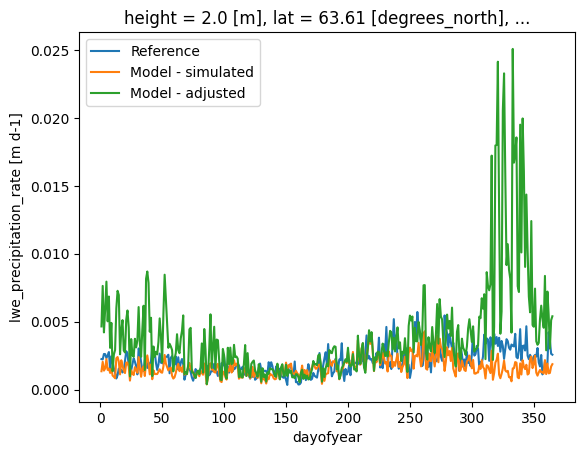

In [1]:
import xarray as xr
from xclim import sdba
from dask.distributed import Client
from xclim import units
from xclim.sdba.detrending import LoessDetrend
import dask
from dask_jobqueue import SLURMCluster
from baeda import *

# we have to make some big chunks and this will silence a warning about that
dask.config.set(**{"array.slicing.split_large_chunks": False})

# client = Client()
# Cell for testing purposes only
cluster = SLURMCluster(
    cores=24,
    memory="128GB",
    # queue="debug",
    queue="t2small",
    # walltime="01:00:00",
    walltime="12:00:00",
    log_directory=".",
    account="cmip6",
    interface="ib0",
)

client = Client(cluster)
cluster.scale(1)


log_dir = "."
ref_var_id = "tp"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = get_era5_fps(ref_var_id, ref_start_year, ref_end_year)

var_id = "pr"
model = "MIROC6"
hist_start_year = 1993
hist_end_year = 2014
hist_fps = get_cmip6_fps(model, "historical", var_id, hist_start_year, hist_end_year)

scenario = "ssp585"
sim_ref_start_year = 2015
sim_ref_end_year = 2022
sim_ref_fps = get_cmip6_fps(
    model, scenario, var_id, sim_ref_start_year, sim_ref_end_year
)

hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
ref_ds = (
    xr.open_mfdataset(ref_fps)
    .convert_calendar("noleap")
    .sel(expver=1)
    .drop_vars("expver")
)

# We will speed things up and only work on a single pixel
bad_lat, bad_lon = 63.61, 178.75
sel_di = dict(lat=bad_lat, lon=bad_lon)

ref = get_rechunked_da(ref_ds, ref_var_id).sel(sel_di, method="nearest")
hist = get_rechunked_da(hist_ds, var_id).sel(sel_di, method="nearest")

ref.attrs["units"] = "m d-1"
ref = sdba.processing.jitter_under_thresh(ref, thresh="0.01 mm d-1")
hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

dqm = sdba.DetrendedQuantileMapping.train(
    ref=ref,
    hist=hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")

# convert model data to meters / day to match ref and scen
hist_mpd = units.convert_units_to(hist, "m d-1")

# now the adjustment object / task graph
scen = dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
plot_avg_ts(ref, hist_mpd, scen)

### Exploring the over-adjustment

There is something weird going on here! Averaged adjusted data is upwards of ~10x highger than reference data. This looks like a possible over-correction, in multiple spots.

For example, the maximum adjusted precip value is:

In [2]:
scen.values.max()

0.3439821664451821

That's m / d, so, that's a lot of rain. Rivaling maximum daily rainflal records in SE alaska. The maximum unadjusted value is 10x smaller:

In [3]:
hist_mpd.values.max()

0.029467321382981027

And the maximum reference value is more similar to the maximum unadjusted value:

In [1]:
"CESM2  CESM2-WACCM  CNRM-CM6-1-HR  EC-Earth3-Veg  GFDL-ESM4  HadGEM3-GC31-LL  HadGEM3-GC31-MM  KACE-1-0-G  MIROC6  MPI-ESM1-2-LR  NorESM2-MM  TaiESM1".split()

['CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1-HR',
 'EC-Earth3-Veg',
 'GFDL-ESM4',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'KACE-1-0-G',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'NorESM2-MM',
 'TaiESM1']

In [4]:
ref.values.max()

0.048606947

### Adjustment factors and quantiles

Let's look at the adjustment factors created here. They are stored in the adjustment object:

Here are the adjustment factors for day 150, a day where the average precipitation is relatively similar across the reference, modeled, and adjusted data (see previous chart):

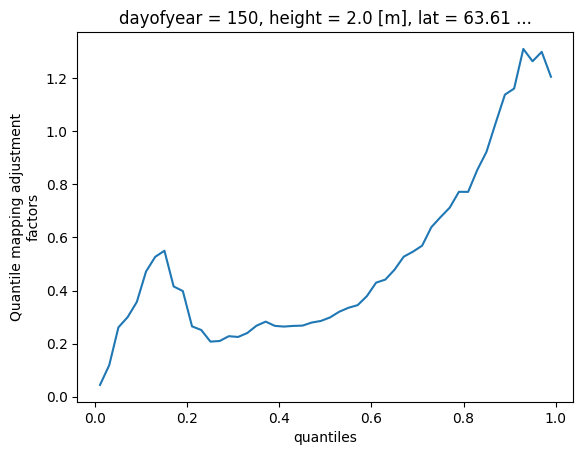

In [5]:
dqm.ds.af.sel(dayofyear=150).plot(x="quantiles")

And now for day 340, which has a much higher adjusted average than both reference and model:

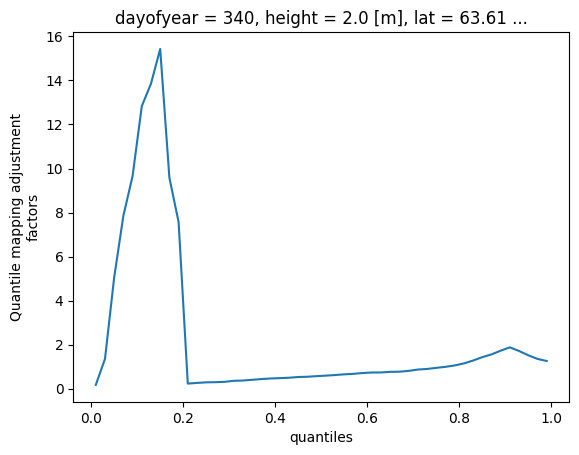

In [6]:
dqm.ds.af.sel(dayofyear=340).plot(x="quantiles")

Some adjustment factors here are an order of magnitude larger than all of the others. 

It looks like the 0.15 quantile has the largest adjustment factor:

In [7]:
dqm.ds.af.sel(quantiles=0.15, dayofyear=340).values

array(15.44419064)

Let's look at the ratio of the quantiles between the reference and model data for these two days of year. This ratio is the basis of the adjustment factor (there may be some other things going on that influence the final adjustment factor):

For day 150:

In [8]:
print_q15_ratio(ref, hist, doy=150)

doy 150, model: 0.000029904
doy 150, reference: 0.000005235
Ratio (ref / hist): 0.18


For day 340:

In [9]:
print_q15_ratio(ref, hist, doy=340)

doy 340, model: 0.000010191
doy 340, reference: 0.000224158
Ratio (ref / hist): 21.99


So yeah, this seems to agree with what we have seen for adjustment factors between the two days-of-year. The question is, why?!

### Improvement with jitter step

Experimenting with the jitter step, we can see that things actually look better for this pixel if we change the "jitter under" threshold to be 0.1 mm/d:

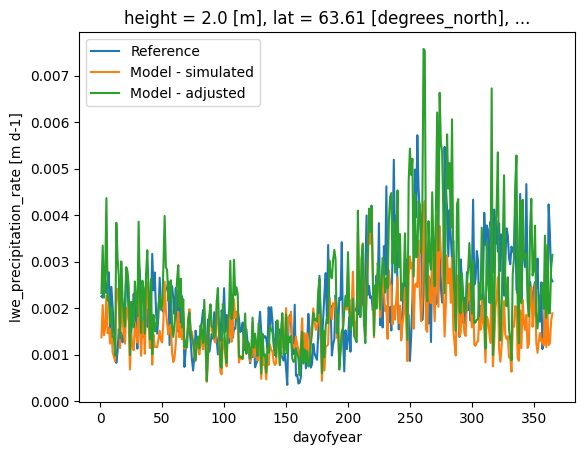

In [10]:
ref_ju01 = get_rechunked_da(ref_ds, ref_var_id).sel(sel_di, method="nearest")
hist_ju01 = get_rechunked_da(hist_ds, var_id).sel(sel_di, method="nearest")

ref_ju01.attrs["units"] = "m d-1"

# change made here - 0.1 mm / d instead of 0.01 mm / d
ref_ju01 = sdba.processing.jitter_under_thresh(ref_ju01, thresh="0.1 mm d-1")
hist_ju01 = sdba.processing.jitter_under_thresh(hist_ju01, thresh="0.1 mm d-1")

dqm_ju01 = sdba.DetrendedQuantileMapping.train(
    ref_ju01,
    hist_ju01,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

scen_ju01 = dqm_ju01.adjust(
    hist_ju01, extrapolation="constant", interp="nearest", detrend=det
)


hist_ju01_mpd = units.convert_units_to(hist_ju01, "m d-1")
plot_avg_ts(ref, hist_ju01_mpd, scen_ju01)

plt.legend()

Definitely not seeing the craziness we saw before. Here is the monthly-based chart which is a little cleaner:

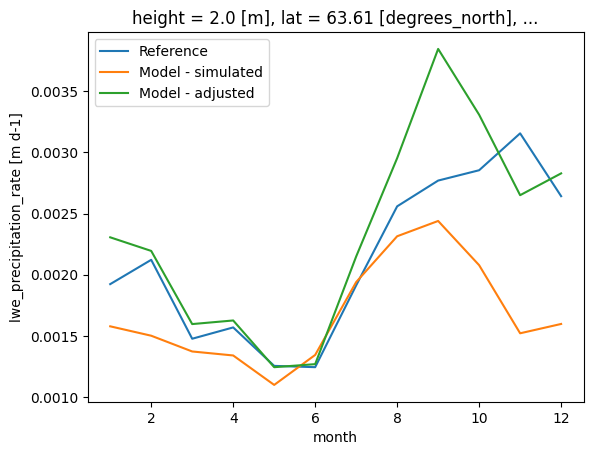

In [11]:
plot_avg_ts(ref, hist_ju01_mpd, scen_ju01, gb_str="time.month")

Still some apparent over adjustment, but definitely much better.

### Exploring the improvement

We'll just dig in a bit here to try and get a better understanding of why increasing the jitter-under threshold by 10x seems to have improved the adjustment (or, at least helped the serious over-corrections we saw).

Here are the adjustment factors again:

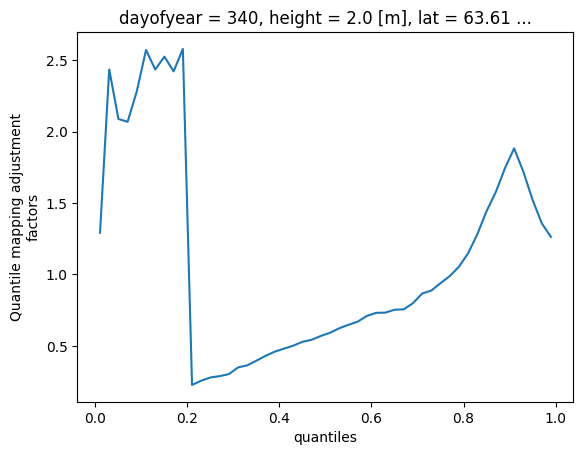

In [12]:
dqm_ju01.ds.af.sel(dayofyear=340).plot(x="quantiles")

And the quantile values again for these data which have been jittered with this 0.1 mm/d threshold:

In [13]:
print_q15_ratio(ref, hist_ju01_mpd, doy=150)

doy 150, model: 0.000072629
doy 150, reference: 0.000005235
Ratio (ref / hist): 0.07


In [14]:
print_q15_ratio(ref, hist_ju01_mpd, doy=340)

doy 340, model: 0.000046504
doy 340, reference: 0.000224158
Ratio (ref / hist): 4.82


So with that different jitter threshold, we see a marked decrease in the ref: hist ratio. 

And look at this - the "hist_q" values for the 0.15 quantile are quite different between the two different preprocessing thresholds. The hist_q value is ~5 times larger for the model data which has been jittered with 0.1 mm/d threshold vs the 0.01 mm/d threshold:

In [15]:
dqm.ds.hist_q.sel(dayofyear=340, quantiles=0.15).values

array(0.00515668)

In [16]:
dqm_ju01.ds.hist_q.sel(dayofyear=340, quantiles=0.15).values

array(0.03181454)

I think what we can take away from this is that we should probably do some sort of profiling to settle on defensible values for the jitter-under and frequency adaptation thresholds, instead of just relying solely on the values used in the Lavoie et al. pipeline. 

## Profiling 

Here we will perform a profiling analysis for at least a semi-objective way of a selecting the parameter values which seem to give the best adjustments. We will use DOY summaries because these should be reasonably close between adjusted historical simulations and the reference ERA5 data when the adjustment goes well. We can use some type of distance metric to score the adjusted data - RMSE is an easy first choice. 

We have defined some functions for doing this in the `baeda` module.

Now let's test out our new function with the two different jitter thresholds we have tested so far: 0.01 mm / d and 0.1 mm /d, for the bad pixel only. 

I would expect to see a higher RMSE for the 0.01 mm / d threshold, given that it produced visibly more over-adjusted data. 

In [17]:
rmse_ = run_adjust_and_compute_doy_rmse(ref, hist, det, ju_thresh="0.01 mm d-1")
print(rmse_)

ValueError: group_dqm_train failed on block with coords : Coordinates:
  * time     (time) object 1993-01-01 00:00:00 ... 2022-12-31 12:00:00.

In [ ]:
rmse_ = run_adjust_and_compute_doy_rmse(ref, hist, det, ju_thresh="0.1 mm d-1")
print(rmse_)

KeyboardInterrupt: 

Okay so that's good, we do see a larger RMSE for the 0.01 mm/d jitter-under threshold. 


Now, it would be ideal if we can do this for the entire grid. We can treat this single value as a crude measurement of how good the bias correction is as a whole. 

Let's run it (it will probably take a while to solve, in testing so far things are taking slightly under 10 minutes)

In [ ]:
# whole grid
ref = get_rechunked_da(ref_ds, ref_var_id)
hist = get_rechunked_da(hist_ds, var_id)

ju_thresh = "0.01 mm d-1"

# breaking this down into separate steps so we can look at different stats
# adapt freq thresh default is 1 mm / d
scen = run_adjust(ref, hist, det, ju_thresh=ju_thresh)
ref_doy_means_a = doy_stats(ref, stat_func=np.mean)
scen_doy_means_a = doy_stats(scen, stat_func=np.mean)
rmse_a = rmse(ref_doy_means_a.values, scen_doy_means_a.values)
print(rmse_)

/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 15.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


RMSE: 0.0011010913768633149


In [ ]:
ju_thresh = "0.1 mm d-1"

scen = run_adjust(ref, hist, det, ju_thresh=ju_thresh)
ref_doy_means_b = doy_stats(ref, stat_func=np.mean)
scen_doy_means_b = doy_stats(scen, stat_func=np.mean)
rmse_b = rmse(ref_doy_means_b.values, scen_doy_means_b.values)
print(rmse_b)

/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 15.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


RMSE: 0.0010046330682538828


Wow, so it looks like the 0.1 mm/d threshold is lower by 0.0001.

Let's compare the largest differences between doy-means of adjusted and unadjusted data:

In [ ]:
# Calculate the absolute difference between scen_doy_means_a and ref_doy_means_a
diff_a = np.abs(scen_doy_means_a - ref_doy_means_a)
diff_a.where(diff_a >= 0.05, drop=True).squeeze()

<xarray.DataArray (dayofyear: 2)>
array([0.05297761, 0.05008173])
Coordinates:
    lat          float64 54.19
    lon          float64 138.8
    height       float64 2.0
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 322 324

In [ ]:
# Calculate the absolute difference between scen_doy_means_a and ref_doy_means_a
diff_b = np.abs(scen_doy_means_b - ref_doy_means_b)
diff_b.where(diff_b >= 0.026, drop=True).squeeze()

<xarray.DataArray (dayofyear: 3, lat: 3, lon: 5)>
array([[[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [0.02663712, 0.02759992, 0.02693427,        nan,        nan]],

       [[       nan,        nan,        nan,        nan, 0.02702948],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan, 0.0267962 ,        nan],
        [       nan,        nan,        nan,        nan,        nan]]])
Coordinates:
  * lat          (lat) float64 51.36 56.07 60.79
  * lon          (lon) float64 -148.8 -147.5 -145.0 -131.2 -126.2
    height       float64 2.0
    spatial_ref  int64 0
  * dayofyear    (dayofyear) int64 271 324 340

So what we can see here is the maximum differences between adjusted and reference day-of-year means have about halved under the 0.1 mm/d jitter under threshold. This is in agreement with the RMSE score on these differences. 

And for the pixel we were looking at earlier:

In [ ]:
(
    scen_doy_means_a.sel(lat=bad_lat, lon=bad_lon, method="nearest")
    - ref_doy_means_a.sel(lat=bad_lat, lon=bad_lon, method="nearest")
).max()

<xarray.DataArray ()>
array(0.02188901)
Coordinates:
    lat          float64 63.61
    lon          float64 178.8
    height       float64 2.0
    spatial_ref  int64 0

In [ ]:
(
    scen_doy_means_b.sel(lat=bad_lat, lon=bad_lon, method="nearest")
    - ref_doy_means_b.sel(lat=bad_lat, lon=bad_lon, method="nearest")
).max()

<xarray.DataArray ()>
array(0.00549672)
Coordinates:
    lat          float64 63.61
    lon          float64 178.8
    height       float64 2.0
    spatial_ref  int64 0

... the maximum difference between adjusted and reference is almost 5 times less under this option too. 

And look, if we increase the jitter-under threshold even further, it might give an even better result:

In [ ]:
rmse_ = run_adjust_and_compute_doy_rmse(ref, hist, det, ju_thresh="0.2 mm d-1")
print(rmse_)

/home/kmredilla/miniconda3/envs/new_cmip6_utils/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 15.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


RMSE: 0.0009901003372564823


So we are seeing the lowest RMSE for the 0.2 mm/d jitter-under threshold for the MIROC6 model. It probably makes sense to perform an analysis to pick the best thresholds we can. 